<a href="https://colab.research.google.com/github/babsyco/Background_infraredLight_filtering/blob/main/code/NSW_loc_alerts_sample_lines_newSparseAdded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tracking NSW Location Alerts for the June/July 2021 Outbreak

This notebook tallies the number of locations per day for each type of location alert issued by NSW Health. They are tallied by date of exposure event (as opposed to date of public notification). The six alert types are officially labeled:

* Transmission venues of concern
* Close contacts – Get tested immediately and self-isolate for 14 days
* Casual contacts - Get tested immediately and self-isolate until you get a negative result
* Casual contacts – Get tested immediately (people with no symptoms do not need to self-isolate)
* Monitor for symptoms
* Public transport routes

## Method
Individual exposure sites are tallied by event date and alert type using the most recent datasets archived [here](https://github.com/babsyco/C19_NSW_location_alerts), which are sourced from NSW Health [here](https://www.health.nsw.gov.au/Infectious/covid-19/Pages/case-locations-and-alerts.aspx). Within these datasets, exposure events are grouped by venue: events per venue (per dataset) are listed in the "Date and time of exposure" column, and all dates listed in this column follow the format "DD \<month\> YYYY", eg (underlined in green):

<body>
  <br>
  <center>
  <figure>
    <img src="https://drive.google.com/uc?export=download&id=1Ijr5v1pVhcKvCZQjULtBgDH0qdDhNXgk" width="900" align="middle">
    <figcaption>Sample of the 'Close contacts' dataset.</figcaption>
  </figure>
  </center>
<br>
</body>

 This means that by scanning entries in this column for the string "2021", these date strings can be extracted, producing each exposure date per venue. Some data cleaning is also done (see the function `get_date_tallies()` below) to ensure anomalies (double whitespaces, typos etc) are fixed.

### Potential Errors
#### Missed Dates
Event dates may pass undetected if:
* The format '21' is used to represent the year 2021, however this is not seen to be the case anywhere in these datasets. 
* There is a typo in the string '2021', eg '201' (this is an actual typo discovered in one of the datasets). 

However, when '2021' is properly written it will be detected, and these anomalous versions of the string '2021' can be easily searched for using the `get_date_tallies()` function (if the argument `check_year_fmt` is a string it outputs all entries detected that contain that string, for examination).

#### False Positives
Once a date string is extracted, the function `get_date_tallies()` tries to convert the associated string into a datetime value, and if it can not it will thow an error. Several anomalies in the dataset have been detected (and adjusted for) in this way. All dates detected can also easily be output and examined, since the data is currently over a relatively short time period.

In short, where '2021' is correctly written, the event date can not be missed without the user being made aware of it, and it is very unlikely that a typo or text anomaly would still allow a conversion to datetime format and hence a false or incorrect date to be included.

## Troubleshooting
Several code cells contain boolean variables at the top that can be used to configure the cell's output. These can be used to check for anomalies in the data that may need correcting within the `get_date_tallies()` function. This function will also produce an error if a detected string can not be converted to a datetime value. Such text errors will need to be addressed individually within the `text_fixes()` function as they arise.

## Accessing Previous Datasets
Earlier datasets from the [archive repository](https://github.com/babsyco/C19_NSW_location_alerts) can be accessed by setting the `days_back` variable in cell [6] to the desired number of days prior to the most recent dataset available.

In [15]:
import pandas as pd
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import date, timedelta, datetime
import matplotlib.dates as mdates
import numpy as np
from pytz import timezone
from google.colab import files
import os

In [16]:
#############
# FUNCTIONS #
#############

# Function for tallying venues per date
def get_date_tallies(df, column, check_year_fmt):
  date_tallies = {}
  date_format = '%d %B %Y'
  
  for val in df[column]:
    # fix text issues
    val = text_fixes(val)
    # check for alternative year format if check_year_fmt is a string
    if isinstance(check_year_fmt, str) and check_year_fmt in val:
      print("\nNote: the string '%s' has been detected in this entry:\n   %s" % (check_year_fmt, val))
    # find word '2021'
    words = list(val.split(' '))
    for i, word in enumerate(words):
      if '2021' in word:
        # get date string 'DD <month> YYYY' and convert to datetime
        date = datetime.strptime(words[i-2] + ' ' + words[i-1] + ' ' + '2021', date_format)
        # add to dict
        if date in date_tallies.keys():
          date_tallies[date] = date_tallies[date] + 1
        else:  
          date_tallies[date] = 1  
  
  return date_tallies

# Insert any pre-processing text fixes needed into here
def text_fixes(val):
  val = val.replace('  ', ' ')
  val = val.replace(u'\xa0', u' ')
  val = val.replace('201', '2021')
  val = val.replace('Jun ', 'June ')
  val = val.replace('Jul ', 'July ')
  return val

In [17]:
###################
# IMPORT DATASETS #
###################

# OUTPUT OPTIONS
view_dataset_samples = False
list_all_datasets = False

# DATE OFFSET
days_back = 1

# get today's datetime
date_today = datetime.now().astimezone(timezone('Australia/NSW')) - timedelta(days_back)
dateString = date_today.strftime('%d_%m_%Y')
date_2weeks = (datetime.strptime(dateString, "%d_%m_%Y")  - timedelta(14))
changeover_date = datetime.strptime("09_07_2021", "%d_%m_%Y")

# Note: these URLs require a date string of the format 'DD_MM_YYYY' in the '%s' locations to work
locAlert_dataset_URLs = [
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/CC_VOC_%s.csv',
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/casNeg_VOC_%s.csv',
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/cas_VOC_%s.csv',
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/transmit_VOC_%s.csv',
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/monSympt_VOC_%s.csv',
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/PT_VOC_%s.csv'
              ]

dataset_labels = [
            "Close contact locations ",
            "Casual contacts: isolate and test until negative result ",
            "Casual contacts: test immediately (isolate if symptoms) ",
            "Transmission venues of concern ",
            "Monitor for symptoms ",
            "Public transport routes "
            ]

sparse_dataset_URLs = [
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/CCfurNot_VOC_%s.csv',
              'https://raw.githubusercontent.com/babsyco/C19_NSW_location_alerts/main/data/%s_locAlertsNSW/flights_VOC_%s.csv'
]
sparse_dataset_labels = [
              "Close contacts: test/isolate until further notice ",
              "Flights "
]

# import original datasets: tries datasets for today's date then increments back until most recent datasets are found
datasets = {}
datasets['dataset dates'] = []
dateSearch = dateString
while dateSearch != '03_07_2021':
  try:
    for i,label in enumerate(dataset_labels):
      # try importing
      datasets[label + dateSearch] = pd.read_csv(locAlert_dataset_URLs[i] % (dateSearch, dateSearch))
      # fix column name anomaly
      if 'Date of exposure' in datasets[label + dateSearch].columns:
         datasets[label + dateSearch].rename(columns={'Date of exposure':'Date and time of exposure'}, inplace=True)
      # add date to list of dataset dates
      if datetime.strptime(dateSearch, '%d_%m_%Y') not in datasets['dataset dates']:
         datasets['dataset dates'].append(datetime.strptime(dateSearch, '%d_%m_%Y'))
    # decrement date
    dateSearch = (datetime.strptime(dateSearch, '%d_%m_%Y') - timedelta(1)).strftime('%d_%m_%Y')
  except: 
    # decrement date
    dateSearch = (datetime.strptime(dateSearch, '%d_%m_%Y') - timedelta(1)).strftime('%d_%m_%Y')
    continue

# get sparse datasets if after 09/07/2021
dateSearch = dateString
if (date_today.replace(tzinfo=None) - datetime.strptime("09_07_2021", "%d_%m_%Y")).days >= 0:
  while dateSearch != '08_07_2021':
      for i,label in enumerate(sparse_dataset_labels):
        try:
          # try importing
          datasets[label + dateSearch] = pd.read_csv(sparse_dataset_URLs[i] % (dateSearch, dateSearch))
          # fix column name anomaly
          if 'Date of exposure' in datasets[label + dateSearch].columns:
            datasets[label + dateSearch].rename(columns={'Date of exposure':'Date and time of exposure'}, inplace=True)
          if 'Date' in datasets[label + dateSearch].columns:
            datasets[label + dateSearch].rename(columns={'Date':'Date and time of exposure'}, inplace=True)
          # add date to list of dataset dates
          if datetime.strptime(dateSearch, '%d_%m_%Y') not in datasets['dataset dates']:
            datasets['dataset dates'].append(datetime.strptime(dateSearch, '%d_%m_%Y'))
        except: 
          continue
      # decrement date
      dateSearch = (datetime.strptime(dateSearch, '%d_%m_%Y') - timedelta(1)).strftime('%d_%m_%Y')
  dataset_labels.insert(1, sparse_dataset_labels[0])
  dataset_labels.append(sparse_dataset_labels[1])

# import cases dataset
datasets["Local cases."] = pd.read_csv('https://data.nsw.gov.au/data/dataset/c647a815-5eb7-4df6-8c88-f9c537a4f21e/resource/2f1ba0f3-8c21-4a86' +\
                                       '-acaf-444be4401a6d/download/confirmed_cases_table3_likely_source.csv')

# put dataset dates in ascending order
datasets['dataset dates'].reverse()

### CELL OUTPUT ###

# print full list of datasets
if list_all_datasets:
  print('\nALL DATASETS IMPORTED:\n')
  for key in datasets.keys():
    print('  %s' % key)

# display sample of datasets
if view_dataset_samples:
  print('\nDATASET SAMPLES (%s):' % date_today.strftime('%d %B %Y'))
  for dataset in datasets.keys():
    print('\n\n' + dataset[:-1] + (' (Rows = %d):\n' % datasets[dataset].shape[0]))
    display(datasets[dataset].sample(n=min(5, datasets[dataset].shape[0])))

# view list of datasets:
print('\nDATASET DATES IMPORTED:\n')
for date in datasets['dataset dates']:
  print('  %s' % date.strftime('%d_%m_%y'))


DATASET DATES IMPORTED:

  04_07_21
  05_07_21
  06_07_21
  07_07_21
  08_07_21
  09_07_21
  10_07_21


In [18]:
################
# EXTRACT DATA #
################

# OUTPUT OPTIONS
view_event_dataset_sizes = False
view_event_dates = False
view_date_tallies = False
view_daily_total_active_alerts = False
check_year_fmt = False

# Add the 'all alert dates' list and the '<dataset_label> (date tallies)' datasets to datasets dict
datasets['all alert dates'] = []
# access each date's datasets
for dataset_date in datasets['dataset dates']:
  dataset_dateString = dataset_date.strftime('%d_%m_%Y')
  # access each dataset within date
  for label in dataset_labels:
    try:
      datasets[label + dataset_dateString + " (date tallies)"] = get_date_tallies(datasets[label+ dataset_dateString], 'Date and time of exposure', check_year_fmt) 
      # add current dataset's alert dates to 'all alert dates' list
      for alert_date in datasets[label + dataset_dateString + " (date tallies)"].keys():
        datasets['all alert dates'].append(alert_date)
    except:
      continue

# clean up 'all alert dates' list
datasets['all alert dates'] = np.sort(np.unique(datasets['all alert dates']))

# Add all exposure event dates to all '<dataset_label> <dataset_date> (date tallies)' datasets
for alert_date in datasets['all alert dates']:
  for dataset_date in datasets['dataset dates']:
    # convert dataset date to string
    dataset_dateString = dataset_date.strftime('%d_%m_%Y')
    # access each dataset for current date
    for label in dataset_labels:
      try: 
        if alert_date not in datasets[label + dataset_dateString + " (date tallies)"].keys():
          datasets[label + dataset_dateString + " (date tallies)"][alert_date] = 0
      except:
        continue

# get 'total alerts by dataset date' datasets:
for dataset_date in datasets['dataset dates']:
  # convert dataset date to a string
  dataset_dateString = dataset_date.strftime('%d_%m_%Y')
  # initialise a dataset with 'alert date' keys and 0 values
  datasets['aggregated tallies for ' + dataset_dateString] = dict(zip(datasets['all alert dates'], [0]*len(datasets['all alert dates'])))
  # access dataset for each date
  for label in dataset_labels:
    for alert_date in datasets['all alert dates']:
      try:
        datasets['aggregated tallies for ' + dataset_dateString][alert_date] += datasets[label + dataset_dateString + ' (date tallies)'][alert_date]
      except:
        continue

# create list of sample date totals
datasets['sample date totals'] = {}
for dataset_date in datasets['dataset dates']:
  date = dataset_date.strftime('%d_%m_%Y')
  datasets['sample date totals'][date] = sum(datasets['aggregated tallies for ' + date].values())

# get total exposure alert increases for each sample date
datasets['sample date total new alerts'] = {}
for sample_date in datasets['dataset dates'][1:]:  
  # previous dataset date_s string
  prev_date_s = sample_date - timedelta(1)
  sample_dateString = sample_date.strftime('%d_%m_%Y')
  prev_dateString = prev_date_s.strftime('%d_%m_%Y')
  # for each alert type in each sample date
  sample_new_alerts = 0
  for label in dataset_labels:
    label_new_alerts = 0
    try:
      curr_dataset = datasets[label + sample_dateString + ' (date tallies)']
      prev_dataset = datasets[label + prev_dateString + ' (date tallies)']
      # for each exposure event
      for date_e in datasets['all alert dates']:
        # sum new alerts
        label_new_alerts = label_new_alerts + max(0, curr_dataset[date_e] - prev_dataset[date_e])
    except:
      a=1
      # add to total to sample date key:value
    sample_new_alerts = sample_new_alerts + label_new_alerts
  datasets['sample date total new alerts'][sample_date] = sample_new_alerts     

# create daily cases dataset
datasets["Daily local cases."] = {}
# create date keys
for i in range((datasets["all alert dates"][-1] - datasets["all alert dates"][0]).days+1):
  input_date = datasets["all alert dates"][0] + timedelta(i)
  datasets["Daily local cases."][input_date] = np.nan
# tally cases by date
for date in datasets['Local cases.']['notification_date']:
  date = datetime.strptime(date,"%Y-%m-%d")
  if (date >= min(datasets["all alert dates"])) and (date <= max(datasets["all alert dates"])):
    if np.isnan(datasets["Daily local cases."][date]): 
      datasets["Daily local cases."][date] = 1
    else:
      datasets["Daily local cases."][date] = datasets["Daily local cases."][date] + 1

### CELL OUTPUT ###

# check '<dataset_label> (date tallies)' dataset sizes
if view_event_dataset_sizes:
  print('NUMBERS OF ROWS IN DATASETS (should be the same):\n')
  n_rows = 0
  for dataset_date in datasets['dataset dates']:
    # convert dataset date to string
    dataset_dateString = dataset_date.strftime('%d_%m_%Y')
    for label in dataset_labels:
      print("  '%s (date tallies)':\n    %d" % (label, len(datasets[label + dataset_dateString + " (date tallies)"])))

# print dates extracted
if view_event_dates:
  print('\n%d ALERT DATES EXTRACTED:\n' % len(datasets['all alert dates']))
  for i,date in enumerate(datasets['all alert dates']):
    print('  %s --- %d' % (date.strftime("%d %B %Y"), i+1))

# view daily active alert totals
if view_daily_total_active_alerts:
  print('\nAGGREGATED ALERTS ACTIVE ON A GIVEN DATE:\n')
  for dataset_date in datasets['dataset dates']:
    print('\n ' + dataset_date.strftime("%d %B %Y") + ':\n')
    for alert_date in datasets['all alert dates']:
     print('  %s --- %d' % (alert_date.strftime("%d %B %Y"), datasets['aggregated tallies for ' + dataset_date.strftime("%d_%m_%Y")][alert_date]))

# print date tallies
if view_date_tallies:
  print('\nDATE TALLIES:')
  # access each dataset date
  for dataset_date in datasets['dataset dates']:
    dataset_dateString = dataset_date.strftime('%d_%m_%Y')
    # access each dataset for this date:
    for label in dataset_labels:
      print('\n' + label + dataset_dateString)
      for date in datasets['all alert dates']: 
        print('  %s: %d' %(date.strftime("%d_%m_%Y"), datasets[label + dataset_dateString + ' (date tallies)'][date]))

print('\nExposure event dates extracted.')


Exposure event dates extracted.


In [19]:
#############################
# PROCESS DATA FOR PLOTTING #
#############################

n_datasets = len(datasets['dataset dates'])
x_data = list(datasets['all alert dates'])
x_sample_data = datasets['dataset dates'][1:]
newAlerts_y = datasets['sample date total new alerts']
y_datasets = []

# case data
daily_cases_x = sorted(list(datasets["Daily local cases."].keys()))
daily_cases_y = [datasets["Daily local cases."][date] for date in daily_cases_x]
max_daily_cases = max([day for day in daily_cases_y if not np.isnan(day)])
max_dailyNew_alerts = max(newAlerts_y.values())

# exposure tallies datasets
for dataset_date in datasets['dataset dates']:
  dataset = datasets['aggregated tallies for ' + dataset_date.strftime('%d_%m_%Y')]
  y_data = [dataset[x] if (x - dataset_date).days <= 0 else np.nan for x in x_data]
  y_datasets.append(y_data)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

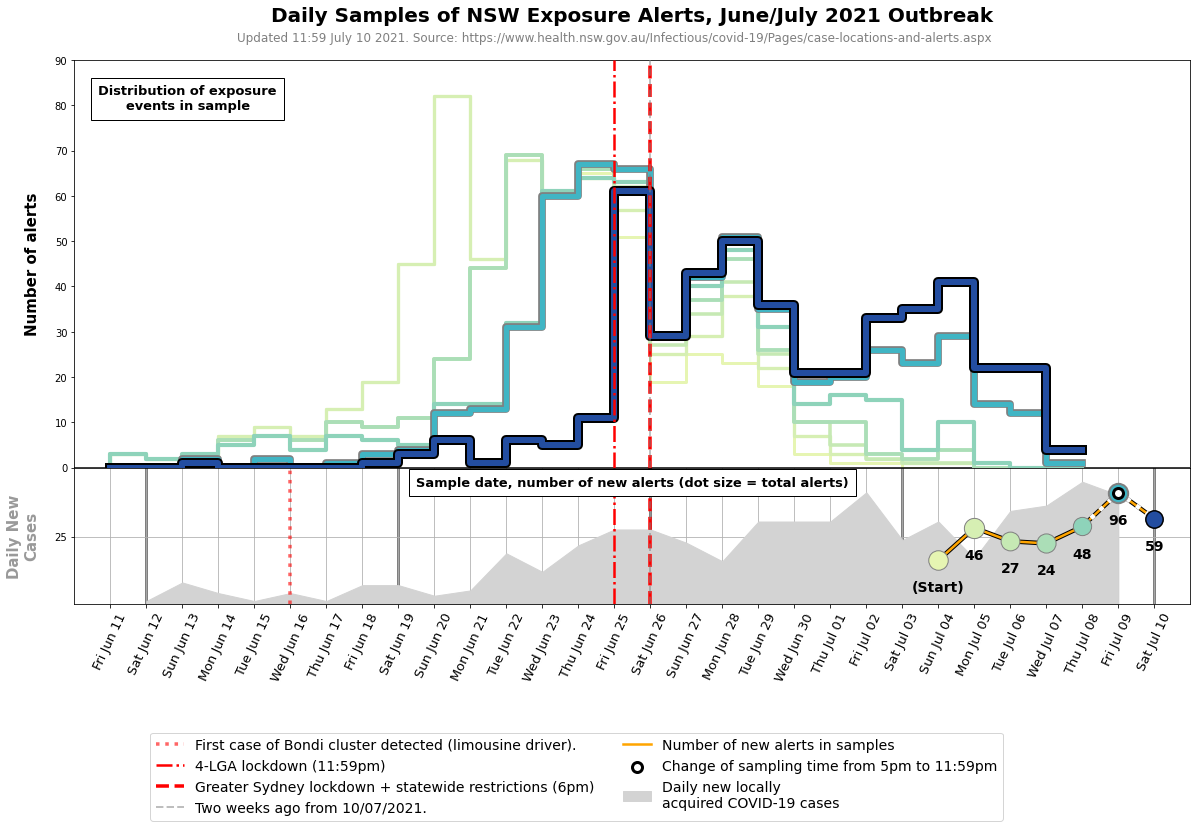

In [20]:
########
# PLOT #
########

# cell output
save_plot = True

# matplotlib settings
plt.rcParams.update({'font.family':'Arial'})

# plot data
n_datasets = len(datasets['dataset dates'])
x_ticks = [min(x_data) + timedelta(i) for i in range((date_today.replace(tzinfo=None) - min(x_data)).days + 1)]
LGA4_lockdown = datetime(2021, 6, 25).astimezone(timezone('Australia/NSW'))
greaterSydney_lockdown = datetime(2021, 6, 26).astimezone(timezone('Australia/NSW'))
limo_case = datetime(2021, 6, 16).astimezone(timezone('Australia/NSW'))
subtitle_string = ("Updated 11:59 %s." % date_today.strftime('%B %d %Y')) +\
                    " Source: https://www.health.nsw.gov.au/Infectious/covid-19/Pages/case-locations-and-alerts.aspx"

# colors
# get colors as hex: https://www.tldevtech.com/hex-color-picker/
colors = list(cm.YlGnBu(list(np.linspace(0.15, 0.35, n_datasets-2)) + [0.5,0.8]))
linecolors = ['grey']*(n_datasets-1) + ['black']
linewidths = [1]*(n_datasets-2) + [2, 1.5]
alpha = 1

# create plot
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(160, 160)
ax1 = fig.add_subplot(gs[:120,0:160])
ax2 = fig.add_subplot(gs[120:160,0:160])
# plot data
width = 2
for i, y_dataset in enumerate(y_datasets[:-1]):
  if i == n_datasets-2:
    width = 3
    ax1.step(x_data, y_dataset, color=linecolors[i], zorder=i+2, linewidth=1.5*(3+width*i/n_datasets))
  ax1.step(x_data, y_dataset, color=colors[i], zorder=i+2, linewidth=3+width*i/n_datasets)
ax1.step(x_data, y_datasets[-1], linewidth=10, color=linecolors[-1], zorder=n_datasets+3)
ax1.step(x_data, y_datasets[-1], linewidth=6, color=colors[-1], zorder=n_datasets+4)

# ax1: format y-axis
ax1.set_ylabel("Number of alerts", fontsize=15, fontweight='bold', labelpad=15)
ax1.set_ylim(0, ax1.get_ylim()[1])
ax1.set_yticks([label for label in ax1.get_yticks() if label >= 0])

# ax2: format y-axis
ax2.set_ylim([0,max_daily_cases*1.1])
ax2.set_yticks([5*round(max_daily_cases/10)])
ax2.set_ylabel("Daily New\nCases", fontsize=15, fontweight='bold', labelpad=15, color='grey', alpha=0.8)

# plot lockdown lines
ax1.plot([LGA4_lockdown]*2, ax1.get_ylim(), color='red', zorder=n_datasets+5, linestyle='dashdot', linewidth=2.5)
ax1.plot([greaterSydney_lockdown]*2, [0, ax1.get_ylim()[1]], color='red', zorder=n_datasets+5, linestyle='--', 
        linewidth=3.5, label='Greater Sydney lockdown + statewide restrictions (6pm)')
ax1.plot([date_2weeks]*2, ax1.get_ylim(), color='grey', linestyle='--', linewidth=2, alpha=0.5, zorder=n_datasets+5)
#ax1.plot([limo_case]*2, [0,ax1.get_ylim()[1]], color='grey', linestyle=':', linewidth=3.5, alpha=0.6,
#       zorder=n_datasets+5, label='First case of Bondi cluster detected (limousine driver).')
ax2.plot([LGA4_lockdown]*2, [0, ax2.get_ylim()[1]], color='red', zorder=2, linestyle='dashdot', linewidth=2.5, label='4-LGA lockdown (11:59pm)')
ax2.plot([greaterSydney_lockdown]*2, [0, ax1.get_ylim()[1]], color='red', zorder=2, linestyle='--', 
        linewidth=3.5, label='Greater Sydney lockdown + statewide restrictions (6pm)')
ax2.plot([limo_case]*2, [0,ax2.get_ylim()[1]], color='red', linestyle=':', linewidth=3.5, alpha=0.6,
       zorder=2, label='First case of Bondi cluster detected (limousine driver).')
ax2.plot([date_2weeks]*2, ax2.get_ylim(), color='grey', linestyle='--', label='Two weeks ago from %s.' % dateString.replace('_', '/'),
         linewidth=2, alpha=0.5, zorder=2)

# x-axis formatting
ax1.set_xticks([])
ax1.set_xlim(min(x_ticks)-timedelta(1), max(x_ticks)+timedelta(1))
ax2.set_xticks(x_ticks)
ax2.set_xlim(min(x_ticks)-timedelta(1), max(x_ticks)+timedelta(1))
ax2.set_xticklabels(x_ticks, rotation=65, fontsize=13)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%a %b %d'))

# add weekday lines
latest_date = datasets['dataset dates'][-1]
while (latest_date - x_data[0]).days > 0:
  ax2.plot([latest_date]*2, list(ax2.get_ylim()), linewidth=3, color='grey', zorder=0, alpha=1)
  latest_date = latest_date - timedelta(7)

# add sample date markers
line_y_data = []
for i in range(n_datasets):
  y_lim = ax2.get_ylim()[1]
  sample_date = datasets['dataset dates'][i]
  # scale values to between 0-0.9
  if i == 0:
    y_point = y_lim*0.32
    line_y_data.append(y_point)
    text = '(Start)'
  else:
    day_new_alerts = datasets['sample date total new alerts'][sample_date]
    y_point = y_lim*(0.32 + 0.5*day_new_alerts/max_dailyNew_alerts)
    line_y_data.append(y_point)
    text = '%d' % day_new_alerts
  ax2.text(sample_date, y_point-y_lim*0.15, text, ha='center', zorder=3, 
        va='top', fontsize=14, fontweight='bold')
  sample_date_total = datasets['sample date totals'][sample_date.strftime('%d_%m_%Y')]
  ax2.scatter([sample_date], [y_point], color=colors[i], zorder=3, 
             s=sample_date_total/1.5, linewidth=linewidths[i], edgecolor = linecolors[i])
ax2.plot(datasets['dataset dates'], line_y_data, zorder=1, linewidth=4.5, color='black')
ax2.plot(datasets['dataset dates'], line_y_data, zorder=2, linewidth=2.5, color='orange', label='Number of new alerts in samples')
# add dotted line for changeover date
changeover_dates = [changeover_date + timedelta(i) for i in [-1,0,1]]
changeover_values = [datasets['sample date total new alerts'][i] for i in changeover_dates]
changeover_values = [y_lim*(0.32 + 0.5*i/max_dailyNew_alerts) for i in changeover_values]
ax2.plot(changeover_dates, changeover_values, zorder=2, linewidth=4.5, linestyle=':', color='white')
ax2.scatter([changeover_date], [changeover_values[1]], color='white', linewidth=3, zorder=4, s=100, 
            edgecolor='black', label='Change of sampling time from 5pm to 11:59pm')

# plot daily case data
# case data: fill plot
daily_cases_y_fill =  [0.9*ax2.get_ylim()[1]*day/max_daily_cases for day in daily_cases_y]
ax2.fill_between(daily_cases_x, daily_cases_y_fill, zorder=1, color='lightgrey', label='Daily new locally\nacquired COVID-19 cases')

#add text boxes
props = dict(facecolor='white', linewidth=1, pad=7)
ax2.text(x_ticks[0]+(x_ticks[-1] - x_ticks[0])/2, ax2.get_ylim()[1]*0.94, 'Sample date, number of new alerts (dot size = total alerts)', 
        bbox=props, ha='center', va='top', fontsize=13, fontweight='bold')
ax1.text(x_ticks[0]+(x_ticks[-1] - x_ticks[0])/13.5, ax1.get_ylim()[1]*0.94, 'Distribution of exposure\nevents in sample', 
        bbox=props, ha='center', va='top', fontsize=13, fontweight='bold', zorder=n_datasets+6)


# ax1: final plot formatting
ax1.plot(list(ax1.get_xlim()),[0]*2,color='black')
ax1.set_title("Daily Samples of NSW Exposure Alerts, June/July 2021 Outbreak", fontsize=20, y=1.08, fontweight='bold')
plt.suptitle(subtitle_string, fontsize=12, y=0.92, color='gray')
ax1.set_axisbelow(True)
plt.grid()
handles, labels = ax2.get_legend_handles_labels()
order = [2,0,1,3,4,5,6]
legend = ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper center', 
                     fontsize=14, ncol=2, bbox_to_anchor=(0.45, -0.9))

# ax: final plot formatting
ax2.set_axisbelow(True)

# save .png of plot
if True:
  if not os.path.exists('plots'):
    os.makedirs('plots')
  filename = 'NSW_2021_locAlerts_sample_lines_' + dateString
  plt.savefig(filename, bbox_inches = 'tight', pad_inches=0.4)
  files.download(filename+'.png')